# Toy Latent Variable Model
Consider a simple latent variable model where we have observations $y_1, \dots, y_n \in \mathbb{R}^d$ drawn from
    \begin{align*}
        z|\theta &\sim \mathcal{N}(\cdot;\theta \textsf{1}_d, \textsf{Id}_d)\\
        y|z &\sim \mathcal{N}(\cdot;z, \textsf{Id}_d)
    \end{align*}
    where $\theta\in\mathbb{R}$ and $\textsf{1}_d, \textsf{Id}_d$ denote the $d$-dimensional vector of ones and the $d\times d$ identity matrix respectively.

In [9]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

import md_lvm
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

## Data

In [2]:
D = 50  # Dimensionality of latent variables.
thdata = 1  # Parameter value used to generate the data.

# Generate the data:
y = np.random.normal(0, 1, (D, 1)) + np.random.normal(thdata, 1, (D, 1))

In [3]:
# get MLE
theta_mle = np.mean(y)
theta_mle

1.0642110879727702

## Compare PGD, IPLA and MD with different stepsizes

In [4]:
#Set approximation parameters:
Niter = 2000  # Number of steps.
N = 200  # Number of particles.

th0 = np.array([0.0])  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [5]:
gamma = 0.01

### Optimal

In [6]:
start = time.time()
th_md, X_md, W_md = md_lvm.md_toy_lvm(y, gamma, Niter, N, th0, X0.T)
end = time.time()
print(end-start)
start = time.time()
th_md2, X_md2, W_md2 = md_lvm.md_toy_lvm_fast(y, gamma, Niter, N, th0, X0.T)
end = time.time()
print(end-start)

428.4570212364197
3.65690016746521


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

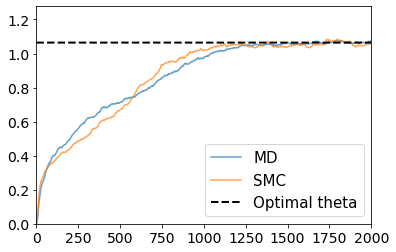

In [7]:
# # Plot parameter estimates as a function of step number k:
plt.plot(th_md, label='MD', alpha = 0.7)
plt.plot(th_md2, label='SMC', alpha = 0.7)
plt.plot(y.mean()*np.ones(Niter), label='Optimal theta', c = 'black', linestyle = 'dashed', lw = 2)
plt.legend(loc='lower right', fontsize = 15)
plt.ylim([0, 1.2*y.mean()])
plt.xlim([0, Niter])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('toy_optimal_gamma.pdf', bbox_inches="tight")

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

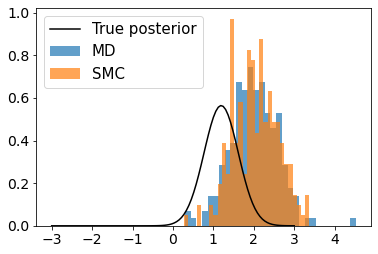

In [8]:
plt.hist(X_md[Niter-1, :, 0], density = True, bins = 30, weights = W_md, label='MD', alpha = 0.7);
plt.hist(X_md2[Niter-1, :, 0], density = True, bins = 30, weights = W_md2, label='SMC', alpha = 0.7);
plt.plot(np.linspace(-3, 3, 100), norm.pdf(np.linspace(-5, 5, 100), scale = np.sqrt(0.5), 
        loc = 0.5*(np.mean(y)+y[0])), label = 'True posterior',
        c = 'black')
plt.legend(fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('toy_optimal_gamma_posterior.pdf', bbox_inches="tight")